In [2]:
# Third-party
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from pyia import GaiaData

In [3]:
# orig_g = Table.read('../data/R1500_z_750_cyl_rv.fits', memmap=True)
# mask = np.isfinite(orig_g['radial_velocity']) & ((orig_g['parallax'] / orig_g['parallax_error']) > 6)
# mask.sum()

g = GaiaData('../data/R1500_z_750_cyl_rv.fits')

In [4]:
c = g.skycoord

In [5]:
np.isfinite(g.e_bp_min_rp_val).sum(), len(g)

(2362392, 3795180)

In [6]:
gal = c.galactic[(g.visibility_periods_used >= 8)]
gal.set_representation_cls('cartesian')

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes[0,0].plot(gal.u, gal.v, marker=',', alpha=0.1, linestyle='none')
axes[1,0].plot(gal.u, gal.w, marker=',', alpha=0.1, linestyle='none')
axes[1,1].plot(gal.v, gal.w, marker=',', alpha=0.1, linestyle='none')
axes[0,1].set_visible(False)

axes[0,0].set_xlim(-500, 500)
axes[0,0].set_ylim(-500, 500)

fig.tight_layout()

In [7]:
plt.hist(g.phot_g_mean_mag[np.isfinite(g.phot_g_mean_mag)], 
         bins=np.linspace(8, 14., 32));
plt.axvline(12.6)

In [33]:
m = 12.6*u.mag
M = 4.5*u.mag
coord.Distance(distmod=m-M)

<Distance 416.86938347 pc>

Note: to be somewhat complete with RVs, we should really only go down to abs. mag ~ 5

Assign reddening by nearest neighbor:

In [34]:
# idx, sep2d, dist3d = c.match_to_catalog_3d(c, nthneighbor=2)

no_ext = np.isnan(g.e_bp_min_rp_val) | np.isnan(g.a_g_val)
idx, sep2d, dist3d = c[no_ext].match_to_catalog_sky(c, nthneighbor=2)

In [35]:
e_bprp = g.e_bp_min_rp_val.value
a_g = g.a_g_val.value

e_bprp[no_ext] = e_bprp[idx]
a_g[no_ext] = a_g[idx]

In [36]:
bprp = (g.phot_bp_mean_mag - g.phot_rp_mean_mag)
G = g.phot_g_mean_mag

bprp0 = bprp - e_bprp*u.mag
G0 = G - a_g*u.mag

In [37]:
# Fe/H = 0, age = 500 Myr
iso = Table.read('/Users/adrian/Downloads/MIST_iso_5b0dc614c6105.iso.cmd', 
                 format='ascii.commented_header', 
                 header_start=12)

# FGK

In [17]:
# F5–K5
tmp_fgk_mask = (g.teff_val.value < 6500.) & (g.teff_val.value > 4400)
test_mask = tmp_fgk_mask & (g.distance < 200*u.pc)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in less
  from ipykernel import kernelapp as app
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


In [39]:
bins = (np.arange(-0.5, 2.5+1e-5, 0.02),
        np.arange(-1, 12+1e-5, 0.02))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axes[0]

# H, xe, ye = np.histogram2d(bprp[test_mask], (G - g.distmod)[test_mask], 
H, xe, ye = np.histogram2d(bprp0[test_mask], (G0 - g.distmod)[test_mask], 
                           bins=bins)
ax.pcolormesh(xe, ye, H.T, cmap='Greys',
              norm=mpl.colors.LogNorm(vmin=1E0, vmax=1E4))

nodes = np.array([[-0.05, 1.1],
                  [-0.05, 1.65],
                  [0.55, 3.65],
                  [0.77, 5],
                  [1, 6],
                  [1.2, 6],
                  [1, 5.2],
                  [0.65, 3.3],
                  [0.4, 2.5],
                  [-0.05, 1.1]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='.')
fgk_path = mpl.patches.Path(nodes)
ax.axhline(6, zorder=-100)

# K5 - F5 
iso_mask = (iso['initial_mass'] <= 1.3) & (iso['initial_mass'] > 0.7)
ax.plot((iso['Gaia_BP_DR2Rev']-iso['Gaia_RP_DR2Rev'])[iso_mask], 
        (iso['Gaia_G_DR2Rev'])[iso_mask], marker='')

_lims = ((iso['Gaia_BP_DR2Rev']-iso['Gaia_RP_DR2Rev'])[iso_mask].min(),
         (iso['Gaia_BP_DR2Rev']-iso['Gaia_RP_DR2Rev'])[iso_mask].max())
fgk_bprp_mask = (bprp0.value > _lims[0]) & (bprp0.value < _lims[1])

ax = axes[1]

# H, xe, ye = np.histogram2d(bprp, G - g.distmod, 
H, xe, ye = np.histogram2d(bprp0, G0 - g.distmod, 
                           bins=bins)
ax.pcolormesh(xe, ye, H.T, cmap='Greys',
              norm=mpl.colors.LogNorm(vmin=1E0, vmax=1E4))
ax.plot(nodes[:, 0], nodes[:, 1], marker='.')

ax.set_ylim(12, -1)
ax.set_xlim(-0.5, 2.5)

fig.tight_layout()

/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in less


In [13]:
xy = np.vstack((bprp0, G0 - g.distmod)).T.value

In [40]:
fgk_mask = fgk_path.contains_points(xy) & fgk_bprp_mask
fgk_mask.sum()

982471

In [41]:
gal_fgk = c.galactic[fgk_mask]
gal_fgk.set_representation_cls('cartesian')

fig, axes = plt.subplots(2, 2, figsize=(8, 7.2), sharex=True, sharey=True)
axes[0,0].plot(gal_fgk.u, gal_fgk.v, 
               marker=',', alpha=0.2, linestyle='none')
axes[1,0].plot(gal_fgk.u, gal_fgk.w, 
               marker=',', alpha=0.2, linestyle='none')
axes[1,1].plot(gal_fgk.v, gal_fgk.w, 
               marker=',', alpha=0.2, linestyle='none')
axes[0,1].set_visible(False)

axes[0,0].set_xlim(-500, 500)
axes[0,0].set_ylim(-500, 500)

fig.tight_layout()

In [43]:
tbl = Table(g[fgk_mask].data)

In [44]:
tbl['bp_rp0'] = bprp0[fgk_mask]
tbl['G0'] = G0[fgk_mask]

In [46]:
tbl.write('../data/fgk.fits', overwrite=True)

# AF

In [19]:
tmp_af_mask = (g.teff_val.value < 10000.) & (g.teff_val.value > 6500)
test_af_mask = tmp_af_mask & (g.distance < 200*u.pc)

/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/Users/adrian/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in greater
/Users/adrian/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in less


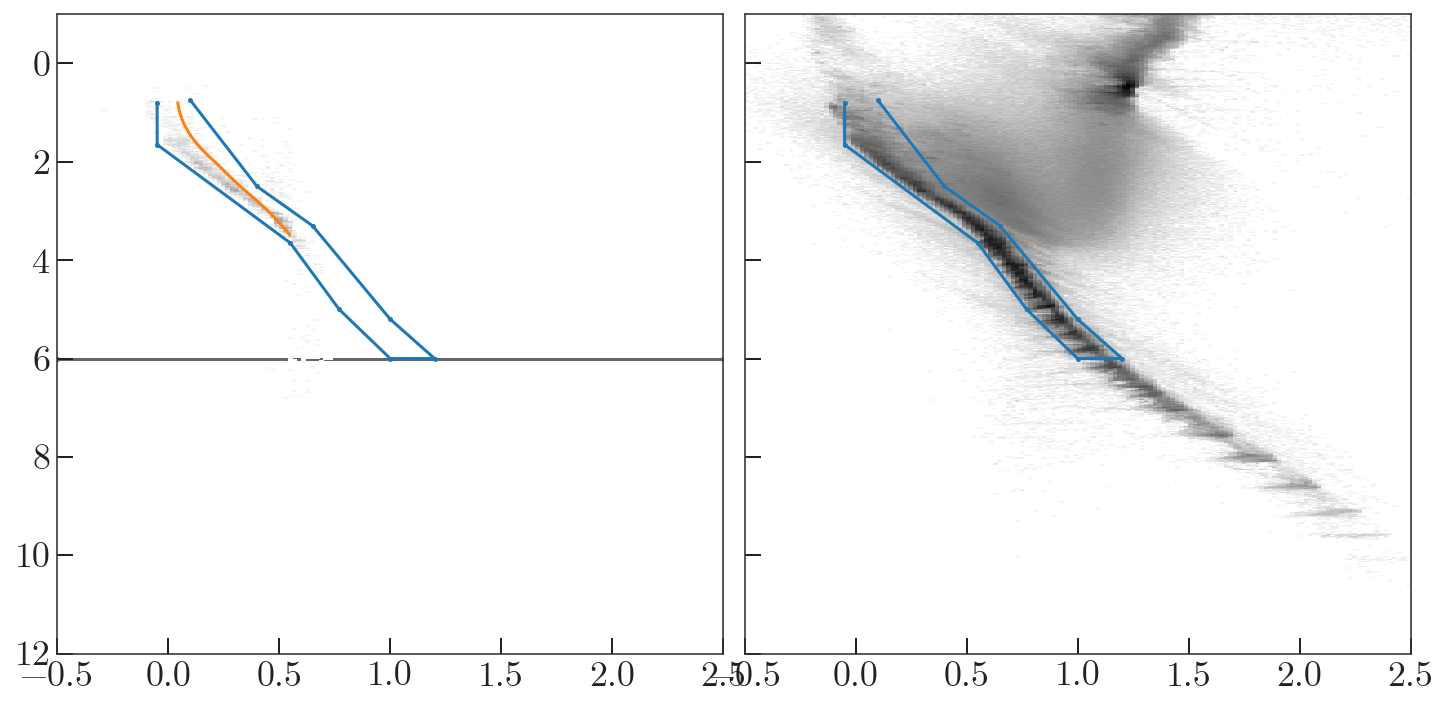

In [50]:
bins = (np.arange(-0.5, 2.5+1e-5, 0.02),
        np.arange(-1, 12+1e-5, 0.02))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axes[0]

H, xe, ye = np.histogram2d(bprp0[test_af_mask], (G0 - g.distmod)[test_af_mask], 
                           bins=bins)
ax.pcolormesh(xe, ye, H.T, cmap='Greys',
              norm=mpl.colors.LogNorm(vmin=1E0, vmax=1E4))

nodes = np.array([[-0.05, 0.8],
                  [-0.05, 1.65],
                  [0.55, 3.65],
                  [0.77, 5],
                  [1, 6],
                  [1.2, 6],
                  [1, 5.2],
                  [0.65, 3.3],
                  [0.4, 2.5],
                  [0.1, 0.75]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='.')
af_path = mpl.patches.Path(nodes)
ax.axhline(6, zorder=-100)

# F5 – A0
iso_mask = (iso['initial_mass'] > 1.3) & (iso['initial_mass'] <= 2.3)
ax.plot((iso['Gaia_BP_DR2Rev']-iso['Gaia_RP_DR2Rev'])[iso_mask], 
        (iso['Gaia_G_DR2Rev'])[iso_mask], marker='')

_lims = ((iso['Gaia_BP_DR2Rev']-iso['Gaia_RP_DR2Rev'])[iso_mask].min(),
         (iso['Gaia_BP_DR2Rev']-iso['Gaia_RP_DR2Rev'])[iso_mask].max())
af_bprp_mask = (bprp0.value > _lims[0]) & (bprp0.value < _lims[1])

ax = axes[1]

# H, xe, ye = np.histogram2d(bprp, G - g.distmod, 
H, xe, ye = np.histogram2d(bprp0, G0 - g.distmod, 
                           bins=bins)
ax.pcolormesh(xe, ye, H.T, cmap='Greys',
              norm=mpl.colors.LogNorm(vmin=1E0, vmax=1E4))
ax.plot(nodes[:, 0], nodes[:, 1], marker='.')

ax.set_ylim(12, -1)
ax.set_xlim(-0.5, 2.5)

fig.tight_layout()

In [51]:
xy = np.vstack((bprp0, G0 - g.distmod)).T.value

In [52]:
af_mask = af_path.contains_points(xy) & af_bprp_mask
af_mask.sum()

484890

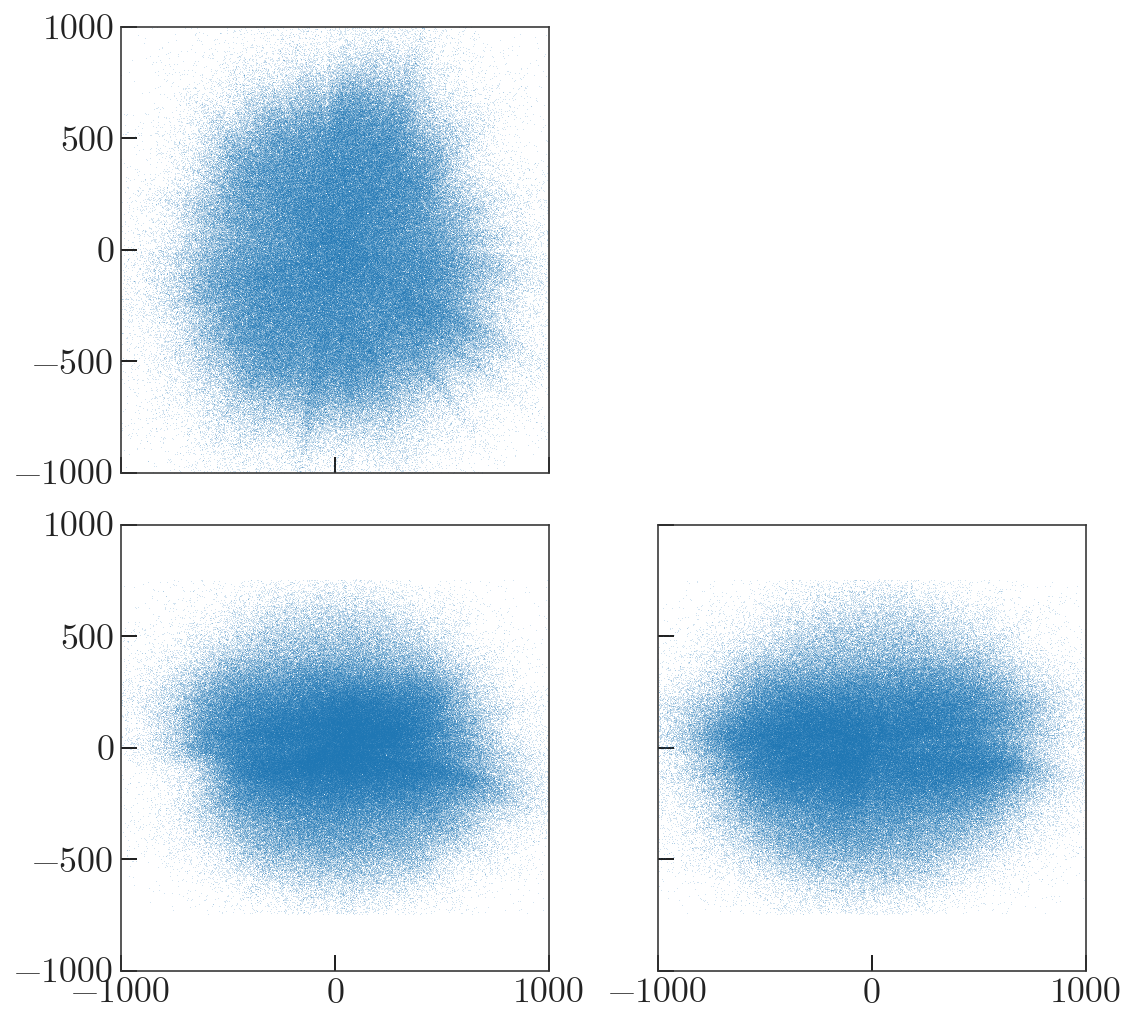

In [55]:
gal_af = c.galactic[af_mask]
gal_af.set_representation_cls('cartesian')

fig, axes = plt.subplots(2, 2, figsize=(8, 7.2), sharex=True, sharey=True)
axes[0,0].plot(gal_af.u, gal_af.v, 
               marker=',', alpha=0.2, linestyle='none')
axes[1,0].plot(gal_af.u, gal_af.w, 
               marker=',', alpha=0.2, linestyle='none')
axes[1,1].plot(gal_af.v, gal_af.w, 
               marker=',', alpha=0.2, linestyle='none')
axes[0,1].set_visible(False)

axes[0,0].set_xlim(-1000, 1000)
axes[0,0].set_ylim(-1000, 1000)

fig.tight_layout()

In [58]:
tbl = g.data[af_mask]

tbl['bp_rp0'] = bprp0[af_mask]
tbl['G0'] = G0[af_mask]

tbl.write('../data/af.fits', overwrite=True)